# Posture Scoring Model Training

This notebook trains an LSTM regression model to predict posture quality scores (0-100) from skeletal keypoint sequences.


In [16]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from model.posture_dataset import PostureDataset
from model.feature_extractor import NUM_FEATURES, get_feature_names
from sklearn.model_selection import train_test_split

In [17]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.16.1
GPU available: []


## 1. Load Dataset


In [18]:
DATA_DIR = "data/neck_stretch"
SEQUENCE_LENGTH = 30  # 30 frames per sequence (~1 second at 30fps)
BATCH_SIZE = 16
OVERLAP = 0.5  # 50% overlap between windows

# Load dataset
dataset = PostureDataset(
    data_dir=DATA_DIR,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=True,
    overlap=OVERLAP,
)

# Get all data for train/test split
X, y = dataset.get_all_data()
print(f"\nDataset shape: X={X.shape}, y={y.shape}")
print(f"Number of features: {NUM_FEATURES}")
print(f"Feature names: {get_feature_names()[:5]}...")

Loaded 2 labels from data/neck_stretch\labels.csv
Created 70 samples from 2 files

Dataset shape: X=(70, 30, 28), y=(70,)
Number of features: 28
Feature names: ['angle_L.Elbow', 'angle_R.Elbow', 'angle_L.Knee', 'angle_R.Knee', 'angle_L.Hip']...


## 2. Train/Validation Split


In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"\nScore range: {y_train.min() * 100:.1f} - {y_train.max() * 100:.1f}")

Training samples: 56
Validation samples: 14

Score range: 85.0 - 90.0


## 3. Create Model


In [20]:
from model.scoring_model import (
    create_scoring_model,
    compile_model,
    create_callbacks,
    get_model_summary,
)

# Create model
model = create_scoring_model(
    sequence_length=SEQUENCE_LENGTH,
    num_features=NUM_FEATURES,
    lstm_units=(64, 32),
    dropout_rate=0.3,
    dense_units=16,
    use_gru=False,  # Use LSTM
)

# Compile model
model = compile_model(
    model,
    learning_rate=0.001,
    loss="mse",
)

# Print summary
print(get_model_summary(model))

Model: "posture_scorer"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keypoint_sequence (InputLayer)  │ (None, 30, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        23,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼─────────────────

## 4. Train Model


In [21]:
EPOCHS = 20
SAVE_DIR = "save"

callbacks = create_callbacks(
    save_dir=SAVE_DIR,
    patience=15,
    min_delta=0.001,
)

# Train
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.1706 - mae: 0.4093
Epoch 1: val_loss improved from None to 0.02753, saving model to save\posture_scorer_best.h5



Epoch 1: finished saving model to save\posture_scorer_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.1113 - mae: 0.3253 - val_loss: 0.0275 - val_mae: 0.1620 - learning_rate: 0.0010
Epoch 2/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0387 - mae: 0.1936
Epoch 2: val_loss improved from 0.02753 to 0.00142, saving model to save\posture_scorer_best.h5



Epoch 2: finished saving model to save\posture_scorer_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0217 - mae: 0.1365 - val_loss: 0.0014 - val_mae: 0.0286 - learning_rate: 0.0010
Epoch 3/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0029 - mae: 0.0493
Epoch 3: val_loss did not improve from 0.00142
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013 - mae: 0.0303 - val_loss: 0.0015 - val_mae: 0.0316 - learning_rate: 0.0010
Epoch 4/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8.8451e-04 - mae: 0.0238
Epoch 4: val_loss did not improve from 0.00142
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 0.0031 - val_mae: 0.0510 - learning_rate: 0.0010
Epoch 5/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0020 - mae: 0.0378
Epoch 5: val_loss did not improve from 0.00142
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0022 - mae: 0.0399 - val_loss: 0.0033 - val_mae: 0.0533 - learning_rate: 0.0010
Epoch 6/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/st


Epoch 8: finished saving model to save\posture_scorer_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.4531e-04 - mae: 0.0214 - val_loss: 0.0011 - val_mae: 0.0266 - learning_rate: 5.0000e-04
Epoch 9/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.7212e-04 - mae: 0.0152
Epoch 9: val_loss improved from 0.00108 to 0.00070, saving model to save\posture_scorer_best.h5



Epoch 9: finished saving model to save\posture_scorer_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.8538e-04 - mae: 0.0183 - val_loss: 6.9829e-04 - val_mae: 0.0233 - learning_rate: 5.0000e-04
Epoch 10/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.7142e-04 - mae: 0.0163
Epoch 10: val_loss improved from 0.00070 to 0.00046, saving model to save\posture_scorer_best.h5



Epoch 10: finished saving model to save\posture_scorer_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.9417e-04 - mae: 0.0194 - val_loss: 4.5546e-04 - val_mae: 0.0205 - learning_rate: 5.0000e-04
Epoch 11/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.9981e-04 - mae: 0.0213
Epoch 11: val_loss improved from 0.00046 to 0.00035, saving model to save\posture_scorer_best.h5



Epoch 11: finished saving model to save\posture_scorer_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.0312e-04 - mae: 0.0189 - val_loss: 3.4657e-04 - val_mae: 0.0184 - learning_rate: 5.0000e-04
Epoch 12/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.7718e-04 - mae: 0.0205
Epoch 12: val_loss improved from 0.00035 to 0.00031, saving model to save\posture_scorer_best.h5



Epoch 12: finished saving model to save\posture_scorer_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.0142e-04 - mae: 0.0181 - val_loss: 3.0547e-04 - val_mae: 0.0171 - learning_rate: 5.0000e-04
Epoch 13/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.6110e-04 - mae: 0.0137
Epoch 13: val_loss improved from 0.00031 to 0.00029, saving model to save\posture_scorer_best.h5



Epoch 13: finished saving model to save\posture_scorer_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.8149e-04 - mae: 0.0175 - val_loss: 2.8809e-04 - val_mae: 0.0165 - learning_rate: 5.0000e-04
Epoch 14/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.9931e-04 - mae: 0.0182
Epoch 14: val_loss improved from 0.00029 to 0.00029, saving model to save\posture_scorer_best.h5



Epoch 14: finished saving model to save\posture_scorer_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.1406e-04 - mae: 0.0187 - val_loss: 2.8701e-04 - val_mae: 0.0166 - learning_rate: 5.0000e-04
Epoch 15/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.0635e-04 - mae: 0.0148
Epoch 15: val_loss did not improve from 0.00029
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.3855e-04 - mae: 0.0162 - val_loss: 2.9947e-04 - val_mae: 0.0168 - learning_rate: 5.0000e-04
Epoch 16/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.2572e-04 - mae: 0.0136
Epoch 16: val_loss did not improve from 0.00029

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.7705e-04 - mae: 0.0152 - val_loss: 3.2630e-04 - val_mae: 0.0172 - learning_rate: 5.0000e-04
Epoch 17/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.9374e-04 - mae: 0.0155
Epoch 17: val_loss did not improve from 0.00029
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss:

## 5. Evaluate Model


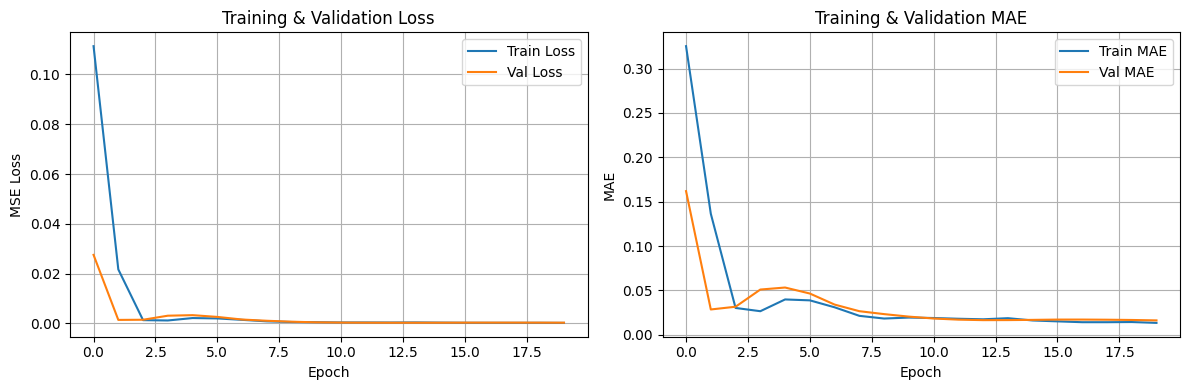

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(history.history["loss"], label="Train Loss")
axes[0].plot(history.history["val_loss"], label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True)

# MAE plot
axes[1].plot(history.history["mae"], label="Train MAE")
axes[1].plot(history.history["val_mae"], label="Val MAE")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MAE")
axes[1].set_title("Training & Validation MAE")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "training_history.png"), dpi=150)
plt.show()

In [23]:
# Final evaluation
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)

print("\n" + "=" * 50)
print("FINAL MODEL EVALUATION")
print("=" * 50)
print(f"Validation MSE Loss: {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation MAE (0-100 scale): {val_mae * 100:.2f}")


FINAL MODEL EVALUATION
Validation MSE Loss: 0.0003
Validation MAE: 0.0184
Validation MAE (0-100 scale): 1.84


## 6. Save Final Model


In [24]:
# Save final model in native Keras format (recommended)
final_model_path = os.path.join(SAVE_DIR, "posture_scorer.keras")
model.save(final_model_path)
print(f"Model saved to: {final_model_path}")

# Also export as SavedModel format for TFLite/TFServing compatibility
savedmodel_path = os.path.join(SAVE_DIR, "posture_scorer_savedmodel")
model.export(savedmodel_path)
print(f"SavedModel exported to: {savedmodel_path}")

Model saved to: save\posture_scorer.keras
INFO:tensorflow:Assets written to: save\posture_scorer_savedmodel\assets


INFO:tensorflow:Assets written to: save\posture_scorer_savedmodel\assets


Saved artifact at 'save\posture_scorer_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 28), dtype=tf.float32, name='keypoint_sequence')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  88311568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1925677904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  88312912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  88322320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  88322704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  88311184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  88316176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  88325392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1966162192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1966162768: TensorSpec(shape=(), dtype=tf.resource, name=None)
SavedModel exported to: save\posture_scorer_savedmodel


## 7. Test Inference


In [25]:
# Load model for inference test
loaded_model = tf.keras.models.load_model(final_model_path)

# Make predictions on validation set
predictions = loaded_model.predict(X_val[:5], verbose=0)

print("\nSample Predictions vs Ground Truth:")
print("-" * 40)
for i, (pred, true) in enumerate(zip(predictions, y_val[:5])):
    print(f"Sample {i + 1}: Predicted={pred[0] * 100:.1f}, True={true * 100:.1f}")

c:\Users\thatt\Documents\Coding Project\AI Project\MoveUp-AI\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Sample Predictions vs Ground Truth:
----------------------------------------
Sample 1: Predicted=86.9, True=85.0
Sample 2: Predicted=87.5, True=85.0
Sample 3: Predicted=88.4, True=90.0
Sample 4: Predicted=87.3, True=85.0
Sample 5: Predicted=87.9, True=90.0
